## Steam Game Recommended Predictor

**CSC 180 Intelligent Systems (Fall 2021)**<br>
**Dr.Haiquan Chen, Dept of Computer Science**<br>
**California State University, Sacramento**<br>

In [1]:
# Christopher Sin (Student ID: 220039041)
# Inigo Jaque     (Student ID: 219976420)
# Final Project
# CSC 180-01 Intelligent Systems Computer Science
# November 28, 2021

**Imports**

In [2]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt

import json
import csv
import pandas as pd
import numpy as np
import gc
import random

import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Conv1D, MaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical
from collections.abc import Sequence

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import shutil
import os

## Data Preprocessing

In [3]:
#Column names that are wanted from the CSV file
columns = ['app_id', 'app_name', 'language', 'review', 'recommended', 'votes_helpful']

#Skips every _____ rows
n_rows = 21000000
skip = np.arange(n_rows)
skip = np.delete(skip, np.arange(0,n_rows, 5000))

#Creates DataFrame (df) and saves every _____ row from steam_reviews.csv into it
#Uses specific columns from the variable columns, reads only _____ rows from the csv file, skips every _____ rows
df = pd.read_csv('steam_reviews.csv', usecols = columns, low_memory = True, nrows = 5000, skiprows = skip)

#displays DataFrame df
df

,app_id,app_name,language,review,recommended,votes_helpful
0,292030,The Witcher 3: Wild Hunt,brazilian,ta bom\n,True,0
1,292030,The Witcher 3: Wild Hunt,english,.,True,0
2,292030,The Witcher 3: Wild Hunt,brazilian,"Jogo muito divertido, uma vez q começa, não da...",True,0
3,292030,The Witcher 3: Wild Hunt,polish,Sztos gierka. Gorąco polecam <3,True,1
4,292030,The Witcher 3: Wild Hunt,schinese,好玩！,True,0
...,...,...,...,...,...,...
4995,517630,Just Cause 4,english,Its not a great game I'm afraid. The constant ...,False,5
4996,517630,Just Cause 4,french,ne pas acheter temps qu'il n'y a pas de correc...,False,3
4997,517630,Just Cause 4,english,2/10 the original half life looks and function...,False,6
4998,517630,Just Cause 4,english,"After futher review, this game is boring and h...",False,0


In [4]:
#Saves reviews only if they are written in English
df = df[df['language'] == 'english']
df['app_id'] = df['app_id'].astype(str)
df['review'] = df['review'].astype(str)

#displays DataFrame df
df

<ipython-input-4-7411668fe75d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['app_id'] = df['app_id'].astype(str)
<ipython-input-4-7411668fe75d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].astype(str)


,app_id,app_name,language,review,recommended,votes_helpful
1,292030,The Witcher 3: Wild Hunt,english,.,True,0
10,292030,The Witcher 3: Wild Hunt,english,"Is an amazin game, every detail. Yes is 2015 g...",True,0
11,292030,The Witcher 3: Wild Hunt,english,Bare Bangin,True,0
16,292030,The Witcher 3: Wild Hunt,english,nice,True,0
20,292030,The Witcher 3: Wild Hunt,english,yes.,True,0
...,...,...,...,...,...,...
4993,517630,Just Cause 4,english,Good god this game is a shit show so far.\n\nS...,False,15
4995,517630,Just Cause 4,english,Its not a great game I'm afraid. The constant ...,False,5
4997,517630,Just Cause 4,english,2/10 the original half life looks and function...,False,6
4998,517630,Just Cause 4,english,"After futher review, this game is boring and h...",False,0


In [5]:
#Groups together the app_id, review, and sets the amount of reviews per app_id = 0
df_review_agg = df.groupby('app_id')['review'].sum()
df_ready_for_sklearn = pd.DataFrame({'app_id': df_review_agg.index, 'review': df_review_agg.values})
df_ready_for_sklearn['review_count'] = 0

#displays DataFrame df_ready_for_sklearn
df_ready_for_sklearn

,app_id,review,review_count
0,1017900,great game beautiful rts,0
1,1055540,A beautiful little game. Buttery smooth contro...,0
2,105600,"Had hours of fun during lockdown, is a great g...",0
3,1056960,Not sure what happened to this game. Did the o...,0
4,1057090,Not sure what to say.... can't put it into wor...,0
...,...,...,...
214,8870,Wow. This game is absolutely stunning. It dese...,0
215,8930,best civ is best civNo off line playing. Dehhh...,0
216,899440,if you are a fan of the series definitely pick...,0
217,945360,"I don't know, Pretty fine.\n Quite unique i...",0


In [6]:
#Gets the length of df and df_ready_for_sklearn
index_df = len(df)
index_df_sklearn = len(df_ready_for_sklearn)

#Loop to count the amount of reviews per Steam Game
for i in range(index_df):
    for j in range(index_df_sklearn):
        if df_ready_for_sklearn['app_id'][j] == df.iloc[i, 0]:
            df_ready_for_sklearn['review_count'][j] += 1
            
#displays DataFrame df_ready_for_sklearn
df_ready_for_sklearn

<ipython-input-6-7406afe179a9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ready_for_sklearn['review_count'][j] += 1


,app_id,review,review_count
0,1017900,great game beautiful rts,1
1,1055540,A beautiful little game. Buttery smooth contro...,1
2,105600,"Had hours of fun during lockdown, is a great g...",74
3,1056960,Not sure what happened to this game. Did the o...,1
4,1057090,Not sure what to say.... can't put it into wor...,1
...,...,...,...
214,8870,Wow. This game is absolutely stunning. It dese...,8
215,8930,best civ is best civNo off line playing. Dehhh...,23
216,899440,if you are a fan of the series definitely pick...,1
217,945360,"I don't know, Pretty fine.\n Quite unique i...",58


In [7]:
#Groups together app_id and recommended
df_review_agg_2 = df.groupby('app_id')['recommended'].sum()
df_ready_for_sklearn_2 = pd.DataFrame({'app_id': df_review_agg_2.index, 'recommended': df_review_agg_2.values})
df_ready_for_sklearn_2

,app_id,recommended
0,1017900,1
1,1055540,1
2,105600,72
3,1056960,0
4,1057090,1
...,...,...
214,8870,7
215,8930,21
216,899440,1
217,945360,55


In [8]:
#Test to see if the reviews have been grouped
print(df_ready_for_sklearn['review'][0])

great game beautiful rts


In [9]:
vectorizer = sk_text.TfidfVectorizer(stop_words = 'english', max_features = 4000, min_df = 2, max_df = .95)
matrix = vectorizer.fit_transform(df_ready_for_sklearn['review'])

In [10]:
tfidf_data = matrix.toarray()
tfidf_data.shape

(219, 3504)

In [11]:
review_array = df_ready_for_sklearn['review_count'].values
review_array.shape
print(df_ready_for_sklearn['review_count'])

0       1
1       1
2      74
3       1
4       1
       ..
214     8
215    23
216     1
217    58
218    10
Name: review_count, Length: 219, dtype: int64


In [12]:
vertical_array = np.vstack(review_array)
x = np.concatenate((tfidf_data, vertical_array), axis = 1)
x.shape

(219, 3505)

In [13]:
y = df_ready_for_sklearn_2['recommended']
y.shape
y.dtypes

dtype('int64')

In [14]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(), label='prediction')
    a = plt.plot(t['y'].tolist(), label='expected')
    
    plt.ylabel('output')
    plt.legend()
    plt.show()

## Fully Connected Convolutional Neural Network  Model

In [15]:
#Setting up x_train, x_test, y_train, y_test and training them
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 11)
x_array_train = x_train
x_array_test = x_test
y_array_train = y_train
y_array_test = y_test
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
(175, 3505)
(175,)
(44, 3505)
(44,)


**Activation = Relu**<br>
**Optimizer = Adam**<br>

In [17]:
#Fully Connected Neural Network?
for i in range (3):
    print("\nRun ", i+1)
    print("Activation: Relu")
    print("Optimizer: Adam\n")
    
    model = Sequential()
    
    model.add(Dense(25, input_dim = x.shape[1], activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1))

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 3, verbose = 1, mode = 'auto')
    model.fit(x_array_train, y_array_train, validation_data = (x_array_test, y_array_test), callbacks = [monitor], verbose = 2, epochs = 1000)

    pred = model.predict(x_test)
    score_mse = metrics.mean_squared_error(pred, y_test)
    print("Score (MSE): {}".format(score_mse))
    
    pred = model.predict(x_test)
    score_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Score(RMSE): {}".format(score_rmse))


Run  1
Activation: Relu
Optimizer: Adam

Epoch 1/1000
6/6 - 0s - loss: 168.7997 - val_loss: 707.4981
Epoch 2/1000
6/6 - 0s - loss: 160.2277 - val_loss: 655.3005
Epoch 3/1000
6/6 - 0s - loss: 153.2955 - val_loss: 604.3624
Epoch 4/1000
6/6 - 0s - loss: 145.3026 - val_loss: 558.6218
Epoch 5/1000
6/6 - 0s - loss: 139.6094 - val_loss: 512.5157
Epoch 6/1000
6/6 - 0s - loss: 131.8855 - val_loss: 469.4140
Epoch 7/1000
6/6 - 0s - loss: 124.8750 - val_loss: 425.8884
Epoch 8/1000
6/6 - 0s - loss: 117.4914 - val_loss: 381.5862
Epoch 9/1000
6/6 - 0s - loss: 110.4285 - val_loss: 335.7054
Epoch 10/1000
6/6 - 0s - loss: 101.2587 - val_loss: 292.7377
Epoch 11/1000
6/6 - 0s - loss: 92.7404 - val_loss: 249.5338
Epoch 12/1000
6/6 - 0s - loss: 82.9416 - val_loss: 210.8996
Epoch 13/1000
6/6 - 0s - loss: 75.6446 - val_loss: 173.0468
Epoch 14/1000
6/6 - 0s - loss: 66.3524 - val_loss: 143.4340
Epoch 15/1000
6/6 - 0s - loss: 58.0080 - val_loss: 120.7993
Epoch 16/1000
6/6 - 0s - loss: 51.3461 - val_loss: 104.20

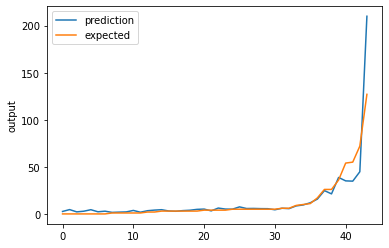

In [18]:
chart_regression(pred.flatten(), y_test, sort = True)

In [19]:
predictions = pd.DataFrame(pred, columns = ['Prediction'])
df_x = pd.DataFrame(x_test).sort_index().reset_index()
true_recommended = y_test.reset_index()

result = pd.concat([df_x, true_recommended, predictions], axis = 1)
show = result
show = show.drop(show.loc[:, ~show.columns.isin(['index', 'recommended', 'Prediction'])], axis = 1)
show.columns = ['index', 'app_id', 'recommended', 'Prediction']
show = show.drop(['index'], axis = 1)
show

,app_id,recommended,Prediction
0,73,0,2.607911
1,202,1,1.623165
2,36,5,5.031623
3,217,55,34.797199
4,60,6,6.023920
5,112,3,4.834821
6,144,2,4.053123
7,141,3,3.519709
8,151,17,15.735341
9,213,3,4.471392


**Activation = Sigmoid**<br>
**Optimizer = Adam**<br>

In [20]:
#Fully Connected Neural Network
for i in range (3):
    print("\nRun ", i+1)
    print("Activation: Sigmoid")
    print("Optimizer: Adam\n")
    
    model = Sequential()
    
    model.add(Dense(25, input_dim = x.shape[1], activation = 'sigmoid'))
    model.add(Dense(10, activation = 'sigmoid'))
    model.add(Dense(1))

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 3, verbose = 1, mode = 'auto')
    model.fit(x_array_train, y_array_train, validation_data = (x_array_test, y_array_test), callbacks = [monitor], verbose = 2, epochs = 1000)

    pred = model.predict(x_test)
    score_mse = metrics.mean_squared_error(pred, y_test)
    print("Score (MSE): {}".format(score_mse))
    
    pred = model.predict(x_test)
    score_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Score(RMSE): {}".format(score_rmse))


Run  1
Activation: Sigmoid
Optimizer: Adam

Epoch 1/1000
6/6 - 0s - loss: 169.0460 - val_loss: 706.6260
Epoch 2/1000
6/6 - 0s - loss: 166.9811 - val_loss: 702.8476
Epoch 3/1000
6/6 - 0s - loss: 165.0373 - val_loss: 698.8474
Epoch 4/1000
6/6 - 0s - loss: 163.0212 - val_loss: 695.2444
Epoch 5/1000
6/6 - 0s - loss: 161.3077 - val_loss: 691.6044
Epoch 6/1000
6/6 - 0s - loss: 159.5069 - val_loss: 688.2360
Epoch 7/1000
6/6 - 0s - loss: 157.8768 - val_loss: 685.4350
Epoch 8/1000
6/6 - 0s - loss: 156.3934 - val_loss: 682.8264
Epoch 9/1000
6/6 - 0s - loss: 155.0471 - val_loss: 680.4556
Epoch 10/1000
6/6 - 0s - loss: 153.7306 - val_loss: 678.3257
Epoch 11/1000
6/6 - 0s - loss: 152.5164 - val_loss: 676.3589
Epoch 12/1000
6/6 - 0s - loss: 151.3664 - val_loss: 674.5569
Epoch 13/1000
6/6 - 0s - loss: 150.3794 - val_loss: 672.7867
Epoch 14/1000
6/6 - 0s - loss: 149.3674 - val_loss: 671.1046
Epoch 15/1000
6/6 - 0s - loss: 148.4352 - val_loss: 669.4744
Epoch 16/1000
6/6 - 0s - loss: 147.5460 - val_los

Epoch 135/1000
6/6 - 0s - loss: 112.3855 - val_loss: 597.1926
Epoch 136/1000
6/6 - 0s - loss: 112.0984 - val_loss: 596.6470
Epoch 137/1000
6/6 - 0s - loss: 111.8254 - val_loss: 596.1130
Epoch 138/1000
6/6 - 0s - loss: 111.5732 - val_loss: 595.5551
Epoch 139/1000
6/6 - 0s - loss: 111.2820 - val_loss: 595.0237
Epoch 140/1000
6/6 - 0s - loss: 111.0633 - val_loss: 594.4399
Epoch 141/1000
6/6 - 0s - loss: 110.7677 - val_loss: 593.9055
Epoch 142/1000
6/6 - 0s - loss: 110.4891 - val_loss: 593.3944
Epoch 143/1000
6/6 - 0s - loss: 110.2416 - val_loss: 592.8607
Epoch 144/1000
6/6 - 0s - loss: 109.9935 - val_loss: 592.3212
Epoch 145/1000
6/6 - 0s - loss: 109.7514 - val_loss: 591.7637
Epoch 146/1000
6/6 - 0s - loss: 109.4890 - val_loss: 591.2126
Epoch 147/1000
6/6 - 0s - loss: 109.2373 - val_loss: 590.6635
Epoch 148/1000
6/6 - 0s - loss: 108.9726 - val_loss: 590.1299
Epoch 149/1000
6/6 - 0s - loss: 108.7408 - val_loss: 589.5596
Epoch 150/1000
6/6 - 0s - loss: 108.4803 - val_loss: 589.0149
Epoch 15

Epoch 269/1000
6/6 - 0s - loss: 87.0528 - val_loss: 533.9727
Epoch 270/1000
6/6 - 0s - loss: 86.9001 - val_loss: 533.5801
Epoch 271/1000
6/6 - 0s - loss: 86.7854 - val_loss: 533.1887
Epoch 272/1000
6/6 - 0s - loss: 86.6286 - val_loss: 532.8224
Epoch 273/1000
6/6 - 0s - loss: 86.5022 - val_loss: 532.4274
Epoch 274/1000
6/6 - 0s - loss: 86.3635 - val_loss: 532.0176
Epoch 275/1000
6/6 - 0s - loss: 86.2304 - val_loss: 531.5967
Epoch 276/1000
6/6 - 0s - loss: 86.0800 - val_loss: 531.1630
Epoch 277/1000
6/6 - 0s - loss: 85.9612 - val_loss: 530.7285
Epoch 278/1000
6/6 - 0s - loss: 85.8057 - val_loss: 530.3377
Epoch 279/1000
6/6 - 0s - loss: 85.6731 - val_loss: 529.9571
Epoch 280/1000
6/6 - 0s - loss: 85.5273 - val_loss: 529.5832
Epoch 281/1000
6/6 - 0s - loss: 85.4121 - val_loss: 529.1535
Epoch 282/1000
6/6 - 0s - loss: 85.2578 - val_loss: 528.7778
Epoch 283/1000
6/6 - 0s - loss: 85.1195 - val_loss: 528.3942
Epoch 284/1000
6/6 - 0s - loss: 85.0074 - val_loss: 527.9463
Epoch 285/1000
6/6 - 0s 

Epoch 404/1000
6/6 - 0s - loss: 71.1489 - val_loss: 485.0680
Epoch 405/1000
6/6 - 0s - loss: 71.0720 - val_loss: 484.7139
Epoch 406/1000
6/6 - 0s - loss: 70.9521 - val_loss: 484.3781
Epoch 407/1000
6/6 - 0s - loss: 70.8519 - val_loss: 484.0376
Epoch 408/1000
6/6 - 0s - loss: 70.7433 - val_loss: 483.7328
Epoch 409/1000
6/6 - 0s - loss: 70.6431 - val_loss: 483.4054
Epoch 410/1000
6/6 - 0s - loss: 70.5493 - val_loss: 483.0700
Epoch 411/1000
6/6 - 0s - loss: 70.4583 - val_loss: 482.7084
Epoch 412/1000
6/6 - 0s - loss: 70.3418 - val_loss: 482.4234
Epoch 413/1000
6/6 - 0s - loss: 70.2418 - val_loss: 482.1309
Epoch 414/1000
6/6 - 0s - loss: 70.1526 - val_loss: 481.7895
Epoch 415/1000
6/6 - 0s - loss: 70.0599 - val_loss: 481.4734
Epoch 416/1000
6/6 - 0s - loss: 69.9504 - val_loss: 481.1613
Epoch 417/1000
6/6 - 0s - loss: 69.8500 - val_loss: 480.8352
Epoch 418/1000
6/6 - 0s - loss: 69.7448 - val_loss: 480.5363
Epoch 419/1000
6/6 - 0s - loss: 69.6631 - val_loss: 480.1934
Epoch 420/1000
6/6 - 0s 

Epoch 539/1000
6/6 - 0s - loss: 59.0530 - val_loss: 444.1579
Epoch 540/1000
6/6 - 0s - loss: 58.9762 - val_loss: 443.9601
Epoch 541/1000
6/6 - 0s - loss: 58.9144 - val_loss: 443.6216
Epoch 542/1000
6/6 - 0s - loss: 58.8220 - val_loss: 443.4428
Epoch 543/1000
6/6 - 0s - loss: 58.7478 - val_loss: 443.1073
Epoch 544/1000
6/6 - 0s - loss: 58.6792 - val_loss: 442.8755
Epoch 545/1000
6/6 - 0s - loss: 58.5934 - val_loss: 442.5402
Epoch 546/1000
6/6 - 0s - loss: 58.5042 - val_loss: 442.2871
Epoch 547/1000
6/6 - 0s - loss: 58.4286 - val_loss: 441.9901
Epoch 548/1000
6/6 - 0s - loss: 58.3366 - val_loss: 441.7731
Epoch 549/1000
6/6 - 0s - loss: 58.2792 - val_loss: 441.4150
Epoch 550/1000
6/6 - 0s - loss: 58.1918 - val_loss: 441.1602
Epoch 551/1000
6/6 - 0s - loss: 58.1048 - val_loss: 440.8435
Epoch 552/1000
6/6 - 0s - loss: 58.0281 - val_loss: 440.6266
Epoch 553/1000
6/6 - 0s - loss: 57.9559 - val_loss: 440.2718
Epoch 554/1000
6/6 - 0s - loss: 57.8655 - val_loss: 440.1635
Epoch 555/1000
6/6 - 0s 

Epoch 674/1000
6/6 - 0s - loss: 49.3068 - val_loss: 408.8451
Epoch 675/1000
6/6 - 0s - loss: 49.2472 - val_loss: 408.5107
Epoch 676/1000
6/6 - 0s - loss: 49.1761 - val_loss: 408.3915
Epoch 677/1000
6/6 - 0s - loss: 49.1162 - val_loss: 408.0753
Epoch 678/1000
6/6 - 0s - loss: 49.0685 - val_loss: 407.9312
Epoch 679/1000
6/6 - 0s - loss: 48.9907 - val_loss: 407.6313
Epoch 680/1000
6/6 - 0s - loss: 48.9377 - val_loss: 407.4749
Epoch 681/1000
6/6 - 0s - loss: 48.8681 - val_loss: 407.1949
Epoch 682/1000
6/6 - 0s - loss: 48.8069 - val_loss: 407.0720
Epoch 683/1000
6/6 - 0s - loss: 48.7495 - val_loss: 406.7479
Epoch 684/1000
6/6 - 0s - loss: 48.6849 - val_loss: 406.6364
Epoch 685/1000
6/6 - 0s - loss: 48.6274 - val_loss: 406.2697
Epoch 686/1000
6/6 - 0s - loss: 48.5588 - val_loss: 406.1782
Epoch 687/1000
6/6 - 0s - loss: 48.4993 - val_loss: 405.7961
Epoch 688/1000
6/6 - 0s - loss: 48.4309 - val_loss: 405.7549
Epoch 689/1000
6/6 - 0s - loss: 48.3679 - val_loss: 405.3240
Epoch 690/1000
6/6 - 0s 

Epoch 809/1000
6/6 - 0s - loss: 41.1507 - val_loss: 379.0549
Epoch 810/1000
6/6 - 0s - loss: 41.1048 - val_loss: 378.9871
Epoch 811/1000
6/6 - 0s - loss: 41.0558 - val_loss: 378.6733
Epoch 812/1000
6/6 - 0s - loss: 40.9871 - val_loss: 378.6302
Epoch 813/1000
6/6 - 0s - loss: 40.9423 - val_loss: 378.2998
Epoch 814/1000
6/6 - 0s - loss: 40.8800 - val_loss: 378.1321
Epoch 815/1000
6/6 - 0s - loss: 40.8306 - val_loss: 377.8790
Epoch 816/1000
6/6 - 0s - loss: 40.7670 - val_loss: 377.7583
Epoch 817/1000
6/6 - 0s - loss: 40.7290 - val_loss: 377.3987
Epoch 818/1000
6/6 - 0s - loss: 40.6665 - val_loss: 377.3239
Epoch 819/1000
6/6 - 0s - loss: 40.6003 - val_loss: 377.0299
Epoch 820/1000
6/6 - 0s - loss: 40.5507 - val_loss: 376.6961
Epoch 821/1000
6/6 - 0s - loss: 40.4934 - val_loss: 376.7434
Epoch 822/1000
6/6 - 0s - loss: 40.4352 - val_loss: 376.1735
Epoch 823/1000
6/6 - 0s - loss: 40.3756 - val_loss: 376.3188
Epoch 824/1000
6/6 - 0s - loss: 40.3222 - val_loss: 375.6068
Epoch 825/1000
6/6 - 0s 

Epoch 70/1000
6/6 - 0s - loss: 142.2464 - val_loss: 659.6414
Epoch 71/1000
6/6 - 0s - loss: 141.9628 - val_loss: 659.1541
Epoch 72/1000
6/6 - 0s - loss: 141.7057 - val_loss: 658.6652
Epoch 73/1000
6/6 - 0s - loss: 141.4845 - val_loss: 658.1407
Epoch 74/1000
6/6 - 0s - loss: 141.2166 - val_loss: 657.6354
Epoch 75/1000
6/6 - 0s - loss: 140.9561 - val_loss: 657.1387
Epoch 76/1000
6/6 - 0s - loss: 140.7062 - val_loss: 656.6605
Epoch 77/1000
6/6 - 0s - loss: 140.4673 - val_loss: 656.1827
Epoch 78/1000
6/6 - 0s - loss: 140.2268 - val_loss: 655.6904
Epoch 79/1000
6/6 - 0s - loss: 139.9886 - val_loss: 655.1946
Epoch 80/1000
6/6 - 0s - loss: 139.7375 - val_loss: 654.7092
Epoch 81/1000
6/6 - 0s - loss: 139.5087 - val_loss: 654.2259
Epoch 82/1000
6/6 - 0s - loss: 139.2706 - val_loss: 653.7635
Epoch 83/1000
6/6 - 0s - loss: 139.0278 - val_loss: 653.3258
Epoch 84/1000
6/6 - 0s - loss: 138.8316 - val_loss: 652.8401
Epoch 85/1000
6/6 - 0s - loss: 138.5888 - val_loss: 652.3792
Epoch 86/1000
6/6 - 0s -

Epoch 203/1000
6/6 - 0s - loss: 120.4939 - val_loss: 613.5535
Epoch 204/1000
6/6 - 0s - loss: 120.3114 - val_loss: 613.2486
Epoch 205/1000
6/6 - 0s - loss: 120.1285 - val_loss: 612.9462
Epoch 206/1000
6/6 - 0s - loss: 119.9557 - val_loss: 612.6348
Epoch 207/1000
6/6 - 0s - loss: 119.7669 - val_loss: 612.3381
Epoch 208/1000
6/6 - 0s - loss: 119.5908 - val_loss: 612.0185
Epoch 209/1000
6/6 - 0s - loss: 119.3926 - val_loss: 611.7065
Epoch 210/1000
6/6 - 0s - loss: 119.2034 - val_loss: 611.3876
Epoch 211/1000
6/6 - 0s - loss: 119.0104 - val_loss: 611.0515
Epoch 212/1000
6/6 - 0s - loss: 118.8306 - val_loss: 610.6843
Epoch 213/1000
6/6 - 0s - loss: 118.6205 - val_loss: 610.3423
Epoch 214/1000
6/6 - 0s - loss: 118.4240 - val_loss: 610.0084
Epoch 215/1000
6/6 - 0s - loss: 118.2418 - val_loss: 609.6630
Epoch 216/1000
6/6 - 0s - loss: 118.0397 - val_loss: 609.3370
Epoch 217/1000
6/6 - 0s - loss: 117.8497 - val_loss: 609.0121
Epoch 218/1000
6/6 - 0s - loss: 117.6631 - val_loss: 608.6906
Epoch 21

Epoch 336/1000
6/6 - 0s - loss: 99.9609 - val_loss: 569.3071
Epoch 337/1000
6/6 - 0s - loss: 99.8411 - val_loss: 569.0149
Epoch 338/1000
6/6 - 0s - loss: 99.7332 - val_loss: 568.7115
Epoch 339/1000
6/6 - 0s - loss: 99.6147 - val_loss: 568.4152
Epoch 340/1000
6/6 - 0s - loss: 99.4872 - val_loss: 568.1331
Epoch 341/1000
6/6 - 0s - loss: 99.3726 - val_loss: 567.8311
Epoch 342/1000
6/6 - 0s - loss: 99.2544 - val_loss: 567.5040
Epoch 343/1000
6/6 - 0s - loss: 99.1264 - val_loss: 567.1937
Epoch 344/1000
6/6 - 0s - loss: 99.0119 - val_loss: 566.8741
Epoch 345/1000
6/6 - 0s - loss: 98.8960 - val_loss: 566.5501
Epoch 346/1000
6/6 - 0s - loss: 98.7534 - val_loss: 566.2518
Epoch 347/1000
6/6 - 0s - loss: 98.6441 - val_loss: 565.9321
Epoch 348/1000
6/6 - 0s - loss: 98.5127 - val_loss: 565.6140
Epoch 349/1000
6/6 - 0s - loss: 98.3976 - val_loss: 565.2939
Epoch 350/1000
6/6 - 0s - loss: 98.2665 - val_loss: 564.9710
Epoch 351/1000
6/6 - 0s - loss: 98.1499 - val_loss: 564.6449
Epoch 352/1000
6/6 - 0s 

Epoch 471/1000
6/6 - 0s - loss: 86.1246 - val_loss: 531.7088
Epoch 472/1000
6/6 - 0s - loss: 86.0373 - val_loss: 531.4604
Epoch 473/1000
6/6 - 0s - loss: 85.9493 - val_loss: 531.2205
Epoch 474/1000
6/6 - 0s - loss: 85.8748 - val_loss: 530.9553
Epoch 475/1000
6/6 - 0s - loss: 85.7740 - val_loss: 530.7048
Epoch 476/1000
6/6 - 0s - loss: 85.6924 - val_loss: 530.4247
Epoch 477/1000
6/6 - 0s - loss: 85.6039 - val_loss: 530.1529
Epoch 478/1000
6/6 - 0s - loss: 85.5072 - val_loss: 529.8934
Epoch 479/1000
6/6 - 0s - loss: 85.4255 - val_loss: 529.6110
Epoch 480/1000
6/6 - 0s - loss: 85.3235 - val_loss: 529.3483
Epoch 481/1000
6/6 - 0s - loss: 85.2441 - val_loss: 529.0696
Epoch 482/1000
6/6 - 0s - loss: 85.1558 - val_loss: 528.8123
Epoch 483/1000
6/6 - 0s - loss: 85.0694 - val_loss: 528.5371
Epoch 484/1000
6/6 - 0s - loss: 84.9769 - val_loss: 528.2839
Epoch 485/1000
6/6 - 0s - loss: 84.9093 - val_loss: 528.0280
Epoch 486/1000
6/6 - 0s - loss: 84.8130 - val_loss: 527.8064
Epoch 487/1000
6/6 - 0s 

Epoch 606/1000
6/6 - 0s - loss: 75.0176 - val_loss: 497.9123
Epoch 607/1000
6/6 - 0s - loss: 74.9309 - val_loss: 497.6562
Epoch 608/1000
6/6 - 0s - loss: 74.8467 - val_loss: 497.4263
Epoch 609/1000
6/6 - 0s - loss: 74.7754 - val_loss: 497.1927
Epoch 610/1000
6/6 - 0s - loss: 74.7046 - val_loss: 496.9590
Epoch 611/1000
6/6 - 0s - loss: 74.6347 - val_loss: 496.7383
Epoch 612/1000
6/6 - 0s - loss: 74.5635 - val_loss: 496.4993
Epoch 613/1000
6/6 - 0s - loss: 74.4839 - val_loss: 496.2829
Epoch 614/1000
6/6 - 0s - loss: 74.4171 - val_loss: 496.0779
Epoch 615/1000
6/6 - 0s - loss: 74.3582 - val_loss: 495.8206
Epoch 616/1000
6/6 - 0s - loss: 74.2769 - val_loss: 495.5764
Epoch 617/1000
6/6 - 0s - loss: 74.1974 - val_loss: 495.3817
Epoch 618/1000
6/6 - 0s - loss: 74.1241 - val_loss: 495.1363
Epoch 619/1000
6/6 - 0s - loss: 74.0586 - val_loss: 494.8622
Epoch 620/1000
6/6 - 0s - loss: 73.9674 - val_loss: 494.6184
Epoch 621/1000
6/6 - 0s - loss: 73.8920 - val_loss: 494.3732
Epoch 622/1000
6/6 - 0s 

Epoch 741/1000
6/6 - 0s - loss: 65.6353 - val_loss: 467.2682
Epoch 742/1000
6/6 - 0s - loss: 65.5648 - val_loss: 467.0540
Epoch 743/1000
6/6 - 0s - loss: 65.5079 - val_loss: 466.8394
Epoch 744/1000
6/6 - 0s - loss: 65.4399 - val_loss: 466.6341
Epoch 745/1000
6/6 - 0s - loss: 65.3903 - val_loss: 466.4138
Epoch 746/1000
6/6 - 0s - loss: 65.3244 - val_loss: 466.1858
Epoch 747/1000
6/6 - 0s - loss: 65.2626 - val_loss: 465.9944
Epoch 748/1000
6/6 - 0s - loss: 65.2048 - val_loss: 465.7633
Epoch 749/1000
6/6 - 0s - loss: 65.1374 - val_loss: 465.5719
Epoch 750/1000
6/6 - 0s - loss: 65.0759 - val_loss: 465.3685
Epoch 751/1000
6/6 - 0s - loss: 65.0152 - val_loss: 465.1563
Epoch 752/1000
6/6 - 0s - loss: 64.9651 - val_loss: 464.9285
Epoch 753/1000
6/6 - 0s - loss: 64.8914 - val_loss: 464.7076
Epoch 754/1000
6/6 - 0s - loss: 64.8293 - val_loss: 464.4966
Epoch 755/1000
6/6 - 0s - loss: 64.7659 - val_loss: 464.2943
Epoch 756/1000
6/6 - 0s - loss: 64.7059 - val_loss: 464.0492
Epoch 757/1000
6/6 - 0s 

Epoch 876/1000
6/6 - 0s - loss: 57.6059 - val_loss: 439.9075
Epoch 877/1000
6/6 - 0s - loss: 57.5421 - val_loss: 439.6127
Epoch 878/1000
6/6 - 0s - loss: 57.4946 - val_loss: 439.4931
Epoch 879/1000
6/6 - 0s - loss: 57.4403 - val_loss: 439.2547
Epoch 880/1000
6/6 - 0s - loss: 57.3826 - val_loss: 439.1143
Epoch 881/1000
6/6 - 0s - loss: 57.3317 - val_loss: 438.8841
Epoch 882/1000
6/6 - 0s - loss: 57.2751 - val_loss: 438.7776
Epoch 883/1000
6/6 - 0s - loss: 57.2265 - val_loss: 438.4975
Epoch 884/1000
6/6 - 0s - loss: 57.1752 - val_loss: 438.3933
Epoch 885/1000
6/6 - 0s - loss: 57.1212 - val_loss: 438.1386
Epoch 886/1000
6/6 - 0s - loss: 57.0737 - val_loss: 438.0232
Epoch 887/1000
6/6 - 0s - loss: 57.0156 - val_loss: 437.7659
Epoch 888/1000
6/6 - 0s - loss: 56.9703 - val_loss: 437.6870
Epoch 889/1000
6/6 - 0s - loss: 56.9170 - val_loss: 437.3875
Epoch 890/1000
6/6 - 0s - loss: 56.8683 - val_loss: 437.4079
Epoch 891/1000
6/6 - 0s - loss: 56.8214 - val_loss: 437.0364
Epoch 892/1000
6/6 - 0s 

Epoch 9/1000
6/6 - 0s - loss: 152.9648 - val_loss: 676.5545
Epoch 10/1000
6/6 - 0s - loss: 151.5856 - val_loss: 674.2820
Epoch 11/1000
6/6 - 0s - loss: 150.3609 - val_loss: 672.1415
Epoch 12/1000
6/6 - 0s - loss: 149.1135 - val_loss: 670.1357
Epoch 13/1000
6/6 - 0s - loss: 148.0385 - val_loss: 668.1344
Epoch 14/1000
6/6 - 0s - loss: 146.9374 - val_loss: 666.3346
Epoch 15/1000
6/6 - 0s - loss: 145.9761 - val_loss: 664.6255
Epoch 16/1000
6/6 - 0s - loss: 145.0519 - val_loss: 663.0286
Epoch 17/1000
6/6 - 0s - loss: 144.1328 - val_loss: 661.6091
Epoch 18/1000
6/6 - 0s - loss: 143.4152 - val_loss: 660.1619
Epoch 19/1000
6/6 - 0s - loss: 142.6230 - val_loss: 658.8331
Epoch 20/1000
6/6 - 0s - loss: 141.9124 - val_loss: 657.5877
Epoch 21/1000
6/6 - 0s - loss: 141.2300 - val_loss: 656.3982
Epoch 22/1000
6/6 - 0s - loss: 140.6225 - val_loss: 655.2262
Epoch 23/1000
6/6 - 0s - loss: 140.0123 - val_loss: 654.0942
Epoch 24/1000
6/6 - 0s - loss: 139.4315 - val_loss: 653.0695
Epoch 25/1000
6/6 - 0s - 

Epoch 143/1000
6/6 - 0s - loss: 108.2923 - val_loss: 588.4385
Epoch 144/1000
6/6 - 0s - loss: 108.0656 - val_loss: 587.8605
Epoch 145/1000
6/6 - 0s - loss: 107.8019 - val_loss: 587.3073
Epoch 146/1000
6/6 - 0s - loss: 107.5520 - val_loss: 586.7770
Epoch 147/1000
6/6 - 0s - loss: 107.3332 - val_loss: 586.2272
Epoch 148/1000
6/6 - 0s - loss: 107.0659 - val_loss: 585.7142
Epoch 149/1000
6/6 - 0s - loss: 106.8548 - val_loss: 585.1766
Epoch 150/1000
6/6 - 0s - loss: 106.6155 - val_loss: 584.6597
Epoch 151/1000
6/6 - 0s - loss: 106.3642 - val_loss: 584.1656
Epoch 152/1000
6/6 - 0s - loss: 106.1529 - val_loss: 583.6445
Epoch 153/1000
6/6 - 0s - loss: 105.9159 - val_loss: 583.1414
Epoch 154/1000
6/6 - 0s - loss: 105.6979 - val_loss: 582.6143
Epoch 155/1000
6/6 - 0s - loss: 105.4543 - val_loss: 582.1071
Epoch 156/1000
6/6 - 0s - loss: 105.2527 - val_loss: 581.5590
Epoch 157/1000
6/6 - 0s - loss: 105.0235 - val_loss: 581.0303
Epoch 158/1000
6/6 - 0s - loss: 104.8030 - val_loss: 580.5062
Epoch 15

Epoch 277/1000
6/6 - 0s - loss: 84.9553 - val_loss: 528.0530
Epoch 278/1000
6/6 - 0s - loss: 84.8417 - val_loss: 527.6434
Epoch 279/1000
6/6 - 0s - loss: 84.6923 - val_loss: 527.2556
Epoch 280/1000
6/6 - 0s - loss: 84.5645 - val_loss: 526.8411
Epoch 281/1000
6/6 - 0s - loss: 84.4446 - val_loss: 526.4282
Epoch 282/1000
6/6 - 0s - loss: 84.2852 - val_loss: 526.0269
Epoch 283/1000
6/6 - 0s - loss: 84.1564 - val_loss: 525.6028
Epoch 284/1000
6/6 - 0s - loss: 84.0275 - val_loss: 525.1967
Epoch 285/1000
6/6 - 0s - loss: 83.8941 - val_loss: 524.8110
Epoch 286/1000
6/6 - 0s - loss: 83.7692 - val_loss: 524.4604
Epoch 287/1000
6/6 - 0s - loss: 83.6528 - val_loss: 524.0787
Epoch 288/1000
6/6 - 0s - loss: 83.5227 - val_loss: 523.7161
Epoch 289/1000
6/6 - 0s - loss: 83.4044 - val_loss: 523.3586
Epoch 290/1000
6/6 - 0s - loss: 83.2934 - val_loss: 522.9819
Epoch 291/1000
6/6 - 0s - loss: 83.1575 - val_loss: 522.6285
Epoch 292/1000
6/6 - 0s - loss: 83.0479 - val_loss: 522.2241
Epoch 293/1000
6/6 - 0s 

Epoch 412/1000
6/6 - 0s - loss: 69.5125 - val_loss: 479.7032
Epoch 413/1000
6/6 - 0s - loss: 69.4106 - val_loss: 479.3900
Epoch 414/1000
6/6 - 0s - loss: 69.3061 - val_loss: 479.0605
Epoch 415/1000
6/6 - 0s - loss: 69.2167 - val_loss: 478.7296
Epoch 416/1000
6/6 - 0s - loss: 69.1079 - val_loss: 478.4429
Epoch 417/1000
6/6 - 0s - loss: 69.0157 - val_loss: 478.1475
Epoch 418/1000
6/6 - 0s - loss: 68.9280 - val_loss: 477.8237
Epoch 419/1000
6/6 - 0s - loss: 68.8347 - val_loss: 477.4788
Epoch 420/1000
6/6 - 0s - loss: 68.7358 - val_loss: 477.1499
Epoch 421/1000
6/6 - 0s - loss: 68.6347 - val_loss: 476.8213
Epoch 422/1000
6/6 - 0s - loss: 68.5358 - val_loss: 476.4723
Epoch 423/1000
6/6 - 0s - loss: 68.4353 - val_loss: 476.1259
Epoch 424/1000
6/6 - 0s - loss: 68.3254 - val_loss: 475.8010
Epoch 425/1000
6/6 - 0s - loss: 68.2371 - val_loss: 475.4359
Epoch 426/1000
6/6 - 0s - loss: 68.1355 - val_loss: 475.0704
Epoch 427/1000
6/6 - 0s - loss: 68.0261 - val_loss: 474.7180
Epoch 428/1000
6/6 - 0s 

Epoch 547/1000
6/6 - 0s - loss: 57.5683 - val_loss: 438.6676
Epoch 548/1000
6/6 - 0s - loss: 57.4975 - val_loss: 438.4093
Epoch 549/1000
6/6 - 0s - loss: 57.4174 - val_loss: 438.1376
Epoch 550/1000
6/6 - 0s - loss: 57.3422 - val_loss: 437.8759
Epoch 551/1000
6/6 - 0s - loss: 57.2651 - val_loss: 437.6277
Epoch 552/1000
6/6 - 0s - loss: 57.1918 - val_loss: 437.3939
Epoch 553/1000
6/6 - 0s - loss: 57.1266 - val_loss: 437.0959
Epoch 554/1000
6/6 - 0s - loss: 57.0490 - val_loss: 436.8393
Epoch 555/1000
6/6 - 0s - loss: 56.9655 - val_loss: 436.5575
Epoch 556/1000
6/6 - 0s - loss: 56.8929 - val_loss: 436.3237
Epoch 557/1000
6/6 - 0s - loss: 56.8242 - val_loss: 436.0286
Epoch 558/1000
6/6 - 0s - loss: 56.7309 - val_loss: 435.7959
Epoch 559/1000
6/6 - 0s - loss: 56.6802 - val_loss: 435.4812
Epoch 560/1000
6/6 - 0s - loss: 56.5822 - val_loss: 435.2144
Epoch 561/1000
6/6 - 0s - loss: 56.5242 - val_loss: 434.9108
Epoch 562/1000
6/6 - 0s - loss: 56.4383 - val_loss: 434.6507
Epoch 563/1000
6/6 - 0s 

Epoch 682/1000
6/6 - 0s - loss: 48.0433 - val_loss: 402.9426
Epoch 683/1000
6/6 - 0s - loss: 47.9906 - val_loss: 402.7267
Epoch 684/1000
6/6 - 0s - loss: 47.9297 - val_loss: 402.5226
Epoch 685/1000
6/6 - 0s - loss: 47.8775 - val_loss: 402.2379
Epoch 686/1000
6/6 - 0s - loss: 47.8094 - val_loss: 402.0381
Epoch 687/1000
6/6 - 0s - loss: 47.7408 - val_loss: 401.7716
Epoch 688/1000
6/6 - 0s - loss: 47.6831 - val_loss: 401.5676
Epoch 689/1000
6/6 - 0s - loss: 47.6275 - val_loss: 401.2779
Epoch 690/1000
6/6 - 0s - loss: 47.5593 - val_loss: 401.0743
Epoch 691/1000
6/6 - 0s - loss: 47.5087 - val_loss: 400.8268
Epoch 692/1000
6/6 - 0s - loss: 47.4440 - val_loss: 400.5328
Epoch 693/1000
6/6 - 0s - loss: 47.3833 - val_loss: 400.3517
Epoch 694/1000
6/6 - 0s - loss: 47.3110 - val_loss: 400.0378
Epoch 695/1000
6/6 - 0s - loss: 47.2602 - val_loss: 399.7999
Epoch 696/1000
6/6 - 0s - loss: 47.1811 - val_loss: 399.5346
Epoch 697/1000
6/6 - 0s - loss: 47.1249 - val_loss: 399.2194
Epoch 698/1000
6/6 - 0s 

Epoch 817/1000
6/6 - 0s - loss: 40.1042 - val_loss: 372.8335
Epoch 818/1000
6/6 - 0s - loss: 40.0355 - val_loss: 372.6867
Epoch 819/1000
6/6 - 0s - loss: 39.9840 - val_loss: 372.5305
Epoch 820/1000
6/6 - 0s - loss: 39.9312 - val_loss: 372.2573
Epoch 821/1000
6/6 - 0s - loss: 39.8771 - val_loss: 372.1652
Epoch 822/1000
6/6 - 0s - loss: 39.8172 - val_loss: 371.8047
Epoch 823/1000
6/6 - 0s - loss: 39.7610 - val_loss: 371.8650
Epoch 824/1000
6/6 - 0s - loss: 39.7161 - val_loss: 371.3635
Epoch 825/1000
6/6 - 0s - loss: 39.6554 - val_loss: 371.5354
Epoch 826/1000
6/6 - 0s - loss: 39.6054 - val_loss: 370.9915
Epoch 827/1000
6/6 - 0s - loss: 39.5453 - val_loss: 371.0382
Epoch 828/1000
6/6 - 0s - loss: 39.4833 - val_loss: 370.6982
Epoch 829/1000
6/6 - 0s - loss: 39.4360 - val_loss: 370.5734
Epoch 830/1000
6/6 - 0s - loss: 39.3744 - val_loss: 370.2827
Epoch 831/1000
6/6 - 0s - loss: 39.3048 - val_loss: 370.2721
Epoch 832/1000
6/6 - 0s - loss: 39.2605 - val_loss: 369.9620
Epoch 833/1000
6/6 - 0s 

Epoch 952/1000
6/6 - 0s - loss: 31.7118 - val_loss: 341.9381
Epoch 953/1000
6/6 - 0s - loss: 31.6436 - val_loss: 341.1579
Epoch 954/1000
6/6 - 0s - loss: 31.5780 - val_loss: 341.0698
Epoch 955/1000
6/6 - 0s - loss: 31.5185 - val_loss: 340.7654
Epoch 956/1000
6/6 - 0s - loss: 31.4548 - val_loss: 340.3164
Epoch 957/1000
6/6 - 0s - loss: 31.4116 - val_loss: 340.1988
Epoch 958/1000
6/6 - 0s - loss: 31.3346 - val_loss: 339.6873
Epoch 959/1000
6/6 - 0s - loss: 31.2807 - val_loss: 339.6642
Epoch 960/1000
6/6 - 0s - loss: 31.2054 - val_loss: 339.0304
Epoch 961/1000
6/6 - 0s - loss: 31.1500 - val_loss: 339.1730
Epoch 962/1000
6/6 - 0s - loss: 31.0725 - val_loss: 338.2267
Epoch 963/1000
6/6 - 0s - loss: 31.0041 - val_loss: 338.2998
Epoch 964/1000
6/6 - 0s - loss: 30.9194 - val_loss: 337.8638
Epoch 965/1000
6/6 - 0s - loss: 30.8617 - val_loss: 337.8129
Epoch 966/1000
6/6 - 0s - loss: 30.8030 - val_loss: 337.2659
Epoch 967/1000
6/6 - 0s - loss: 30.7366 - val_loss: 337.2156
Epoch 968/1000
6/6 - 0s 

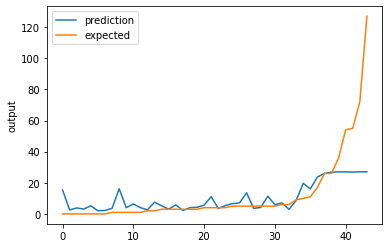

In [21]:
chart_regression(pred.flatten(), y_test, sort = True)

In [22]:
predictions = pd.DataFrame(pred, columns = ['Prediction'])
df_x = pd.DataFrame(x_test).sort_index().reset_index()
true_recommended = y_test.reset_index()

result = pd.concat([df_x, true_recommended, predictions], axis = 1)
show = result
show = show.drop(show.loc[:, ~show.columns.isin(['index', 'recommended', 'Prediction'])], axis = 1)
show.columns = ['index', 'app_id', 'recommended', 'Prediction']
show = show.drop(['index'], axis = 1)
show

,app_id,recommended,Prediction
0,73,0,15.380561
1,202,1,3.628603
2,36,5,6.615132
3,217,55,26.897705
4,60,6,7.071515
5,112,3,4.267108
6,144,2,7.555851
7,141,3,2.218406
8,151,17,23.681932
9,213,3,5.193067


**Activation = Tanh**<br>
**Optimizer = Adam**<br>

In [23]:
#Fully Connected Neural Network
for i in range (3):
    print("\nRun ", i+1)
    print("Activation: Tanh")
    print("Optimizer: Adam\n")
    
    model = Sequential()
    
    model.add(Dense(25, input_dim = x.shape[1], activation = 'tanh'))
    model.add(Dense(10, activation = 'tanh'))
    model.add(Dense(1))

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 3, verbose = 1, mode = 'auto')
    model.fit(x_array_train, y_array_train, validation_data = (x_array_test, y_array_test), callbacks = [monitor], verbose = 2, epochs = 1000)

    pred = model.predict(x_test)
    score_mse = metrics.mean_squared_error(pred, y_test)
    print("Score (MSE): {}".format(score_mse))
    
    pred = model.predict(x_test)
    score_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Score(RMSE): {}".format(score_rmse))


Run  1
Activation: Tanh
Optimizer: Adam

Epoch 1/1000
6/6 - 0s - loss: 154.6954 - val_loss: 668.8152
Epoch 2/1000
6/6 - 0s - loss: 146.2847 - val_loss: 655.5797
Epoch 3/1000
6/6 - 0s - loss: 139.5996 - val_loss: 646.3557
Epoch 4/1000
6/6 - 0s - loss: 135.5353 - val_loss: 640.0416
Epoch 5/1000
6/6 - 0s - loss: 132.2196 - val_loss: 634.8522
Epoch 6/1000
6/6 - 0s - loss: 129.9055 - val_loss: 629.9195
Epoch 7/1000
6/6 - 0s - loss: 128.2260 - val_loss: 627.0938
Epoch 8/1000
6/6 - 0s - loss: 126.8161 - val_loss: 625.0982
Epoch 9/1000
6/6 - 0s - loss: 125.7595 - val_loss: 623.2416
Epoch 10/1000
6/6 - 0s - loss: 124.7026 - val_loss: 621.6230
Epoch 11/1000
6/6 - 0s - loss: 123.8999 - val_loss: 620.0834
Epoch 12/1000
6/6 - 0s - loss: 123.1174 - val_loss: 618.6386
Epoch 13/1000
6/6 - 0s - loss: 122.4261 - val_loss: 617.2249
Epoch 14/1000
6/6 - 0s - loss: 121.7443 - val_loss: 615.8730
Epoch 15/1000
6/6 - 0s - loss: 121.1209 - val_loss: 614.5215
Epoch 16/1000
6/6 - 0s - loss: 120.5207 - val_loss: 

Epoch 136/1000
6/6 - 0s - loss: 79.9858 - val_loss: 513.0928
Epoch 137/1000
6/6 - 0s - loss: 79.7605 - val_loss: 512.4681
Epoch 138/1000
6/6 - 0s - loss: 79.5648 - val_loss: 511.8612
Epoch 139/1000
6/6 - 0s - loss: 79.3400 - val_loss: 511.3103
Epoch 140/1000
6/6 - 0s - loss: 79.1529 - val_loss: 510.6969
Epoch 141/1000
6/6 - 0s - loss: 78.9327 - val_loss: 510.1286
Epoch 142/1000
6/6 - 0s - loss: 78.7571 - val_loss: 509.5060
Epoch 143/1000
6/6 - 0s - loss: 78.5537 - val_loss: 508.8425
Epoch 144/1000
6/6 - 0s - loss: 78.3256 - val_loss: 508.2725
Epoch 145/1000
6/6 - 0s - loss: 78.1299 - val_loss: 507.6904
Epoch 146/1000
6/6 - 0s - loss: 77.9260 - val_loss: 507.0449
Epoch 147/1000
6/6 - 0s - loss: 77.7289 - val_loss: 506.4840
Epoch 148/1000
6/6 - 0s - loss: 77.5165 - val_loss: 505.7531
Epoch 149/1000
6/6 - 0s - loss: 77.3246 - val_loss: 505.2135
Epoch 150/1000
6/6 - 0s - loss: 77.0856 - val_loss: 504.4559
Epoch 151/1000
6/6 - 0s - loss: 76.8847 - val_loss: 503.9069
Epoch 152/1000
6/6 - 0s 

Epoch 271/1000
6/6 - 0s - loss: 56.7468 - val_loss: 438.7780
Epoch 272/1000
6/6 - 0s - loss: 56.6242 - val_loss: 440.9905
Epoch 273/1000
6/6 - 0s - loss: 56.5248 - val_loss: 438.1588
Epoch 274/1000
6/6 - 0s - loss: 56.3894 - val_loss: 438.7394
Epoch 275/1000
6/6 - 0s - loss: 56.2046 - val_loss: 437.8973
Epoch 276/1000
6/6 - 0s - loss: 56.0494 - val_loss: 436.7285
Epoch 277/1000
6/6 - 0s - loss: 55.9025 - val_loss: 437.7071
Epoch 278/1000
6/6 - 0s - loss: 55.7754 - val_loss: 435.8796
Epoch 279/1000
6/6 - 0s - loss: 55.6681 - val_loss: 436.6356
Epoch 280/1000
6/6 - 0s - loss: 55.5182 - val_loss: 435.1729
Epoch 281/1000
6/6 - 0s - loss: 55.3810 - val_loss: 435.2539
Epoch 282/1000
6/6 - 0s - loss: 55.2534 - val_loss: 434.8189
Epoch 283/1000
6/6 - 0s - loss: 55.1211 - val_loss: 434.2525
Epoch 284/1000
6/6 - 0s - loss: 54.9978 - val_loss: 433.9869
Epoch 285/1000
6/6 - 0s - loss: 54.8890 - val_loss: 433.2684
Epoch 286/1000
6/6 - 0s - loss: 54.7502 - val_loss: 433.1003
Epoch 287/1000
6/6 - 0s 

Epoch 406/1000
6/6 - 0s - loss: 41.5588 - val_loss: 386.3053
Epoch 407/1000
6/6 - 0s - loss: 41.4550 - val_loss: 385.4722
Epoch 408/1000
6/6 - 0s - loss: 41.3572 - val_loss: 385.7866
Epoch 409/1000
6/6 - 0s - loss: 41.2736 - val_loss: 384.8119
Epoch 410/1000
6/6 - 0s - loss: 41.1602 - val_loss: 385.3242
Epoch 411/1000
6/6 - 0s - loss: 41.0772 - val_loss: 384.1505
Epoch 412/1000
6/6 - 0s - loss: 40.9893 - val_loss: 384.8899
Epoch 413/1000
6/6 - 0s - loss: 40.8909 - val_loss: 383.4669
Epoch 414/1000
6/6 - 0s - loss: 40.8153 - val_loss: 384.3792
Epoch 415/1000
6/6 - 0s - loss: 40.7189 - val_loss: 383.0101
Epoch 416/1000
6/6 - 0s - loss: 40.6377 - val_loss: 383.8502
Epoch 417/1000
6/6 - 0s - loss: 40.5312 - val_loss: 382.2603
Epoch 418/1000
6/6 - 0s - loss: 40.4611 - val_loss: 383.3919
Epoch 419/1000
6/6 - 0s - loss: 40.3574 - val_loss: 381.6710
Epoch 420/1000
6/6 - 0s - loss: 40.2894 - val_loss: 383.0230
Epoch 421/1000
6/6 - 0s - loss: 40.1763 - val_loss: 380.7325
Epoch 422/1000
6/6 - 0s 

Epoch 541/1000
6/6 - 0s - loss: 30.3831 - val_loss: 345.3028
Epoch 542/1000
6/6 - 0s - loss: 30.3093 - val_loss: 345.4157
Epoch 543/1000
6/6 - 0s - loss: 30.2555 - val_loss: 344.7590
Epoch 544/1000
6/6 - 0s - loss: 30.1452 - val_loss: 344.7958
Epoch 545/1000
6/6 - 0s - loss: 30.0975 - val_loss: 344.2704
Epoch 546/1000
6/6 - 0s - loss: 29.9948 - val_loss: 344.3295
Epoch 547/1000
6/6 - 0s - loss: 29.9429 - val_loss: 343.7422
Epoch 548/1000
6/6 - 0s - loss: 29.8552 - val_loss: 343.9719
Epoch 549/1000
6/6 - 0s - loss: 29.7894 - val_loss: 343.3222
Epoch 550/1000
6/6 - 0s - loss: 29.7268 - val_loss: 343.5738
Epoch 551/1000
6/6 - 0s - loss: 29.6599 - val_loss: 342.9162
Epoch 552/1000
6/6 - 0s - loss: 29.5870 - val_loss: 343.1726
Epoch 553/1000
6/6 - 0s - loss: 29.5304 - val_loss: 342.4165
Epoch 554/1000
6/6 - 0s - loss: 29.4602 - val_loss: 342.6639
Epoch 555/1000
6/6 - 0s - loss: 29.3898 - val_loss: 342.0067
Epoch 556/1000
6/6 - 0s - loss: 29.3222 - val_loss: 342.3996
Epoch 557/1000
6/6 - 0s 

Epoch 52/1000
6/6 - 0s - loss: 101.9182 - val_loss: 572.0808
Epoch 53/1000
6/6 - 0s - loss: 101.5977 - val_loss: 571.1890
Epoch 54/1000
6/6 - 0s - loss: 101.2342 - val_loss: 570.3337
Epoch 55/1000
6/6 - 0s - loss: 100.8892 - val_loss: 569.4885
Epoch 56/1000
6/6 - 0s - loss: 100.5454 - val_loss: 568.6589
Epoch 57/1000
6/6 - 0s - loss: 100.2380 - val_loss: 567.7556
Epoch 58/1000
6/6 - 0s - loss: 99.8642 - val_loss: 566.8963
Epoch 59/1000
6/6 - 0s - loss: 99.5110 - val_loss: 566.0650
Epoch 60/1000
6/6 - 0s - loss: 99.1911 - val_loss: 565.2195
Epoch 61/1000
6/6 - 0s - loss: 98.8606 - val_loss: 564.3806
Epoch 62/1000
6/6 - 0s - loss: 98.5606 - val_loss: 563.4731
Epoch 63/1000
6/6 - 0s - loss: 98.1910 - val_loss: 562.6424
Epoch 64/1000
6/6 - 0s - loss: 97.8708 - val_loss: 561.8223
Epoch 65/1000
6/6 - 0s - loss: 97.5161 - val_loss: 560.9957
Epoch 66/1000
6/6 - 0s - loss: 97.2433 - val_loss: 560.1121
Epoch 67/1000
6/6 - 0s - loss: 96.8842 - val_loss: 559.2703
Epoch 68/1000
6/6 - 0s - loss: 96.

Epoch 187/1000
6/6 - 0s - loss: 69.1984 - val_loss: 479.3488
Epoch 188/1000
6/6 - 0s - loss: 69.0402 - val_loss: 478.6229
Epoch 189/1000
6/6 - 0s - loss: 68.8588 - val_loss: 478.1466
Epoch 190/1000
6/6 - 0s - loss: 68.6713 - val_loss: 477.5832
Epoch 191/1000
6/6 - 0s - loss: 68.4923 - val_loss: 477.0948
Epoch 192/1000
6/6 - 0s - loss: 68.3475 - val_loss: 476.3725
Epoch 193/1000
6/6 - 0s - loss: 68.1347 - val_loss: 476.0587
Epoch 194/1000
6/6 - 0s - loss: 67.9886 - val_loss: 475.3521
Epoch 195/1000
6/6 - 0s - loss: 67.8142 - val_loss: 475.0801
Epoch 196/1000
6/6 - 0s - loss: 67.6635 - val_loss: 474.2470
Epoch 197/1000
6/6 - 0s - loss: 67.4970 - val_loss: 474.0863
Epoch 198/1000
6/6 - 0s - loss: 67.3083 - val_loss: 473.1865
Epoch 199/1000
6/6 - 0s - loss: 67.1609 - val_loss: 473.2497
Epoch 200/1000
6/6 - 0s - loss: 66.9941 - val_loss: 471.9797
Epoch 201/1000
6/6 - 0s - loss: 66.8434 - val_loss: 472.3398
Epoch 202/1000
6/6 - 0s - loss: 66.6786 - val_loss: 470.8184
Epoch 203/1000
6/6 - 0s 

Epoch 322/1000
6/6 - 0s - loss: 49.9484 - val_loss: 412.1188
Epoch 323/1000
6/6 - 0s - loss: 49.8166 - val_loss: 412.3210
Epoch 324/1000
6/6 - 0s - loss: 49.7127 - val_loss: 411.2029
Epoch 325/1000
6/6 - 0s - loss: 49.6035 - val_loss: 411.5304
Epoch 326/1000
6/6 - 0s - loss: 49.4907 - val_loss: 410.4685
Epoch 327/1000
6/6 - 0s - loss: 49.3837 - val_loss: 410.7564
Epoch 328/1000
6/6 - 0s - loss: 49.2881 - val_loss: 409.5472
Epoch 329/1000
6/6 - 0s - loss: 49.1699 - val_loss: 409.9671
Epoch 330/1000
6/6 - 0s - loss: 49.0655 - val_loss: 408.8848
Epoch 331/1000
6/6 - 0s - loss: 48.9504 - val_loss: 409.1063
Epoch 332/1000
6/6 - 0s - loss: 48.8496 - val_loss: 408.1712
Epoch 333/1000
6/6 - 0s - loss: 48.7312 - val_loss: 408.1130
Epoch 334/1000
6/6 - 0s - loss: 48.6120 - val_loss: 407.3603
Epoch 335/1000
6/6 - 0s - loss: 48.5130 - val_loss: 407.0706
Epoch 336/1000
6/6 - 0s - loss: 48.3902 - val_loss: 406.3408
Epoch 337/1000
6/6 - 0s - loss: 48.2818 - val_loss: 406.3494
Epoch 338/1000
6/6 - 0s 

Epoch 457/1000
6/6 - 0s - loss: 36.7199 - val_loss: 365.1140
Epoch 458/1000
6/6 - 0s - loss: 36.6032 - val_loss: 365.4896
Epoch 459/1000
6/6 - 0s - loss: 36.5288 - val_loss: 362.7649
Epoch 460/1000
6/6 - 0s - loss: 36.4359 - val_loss: 365.2953
Epoch 461/1000
6/6 - 0s - loss: 36.3882 - val_loss: 362.8704
Epoch 462/1000
6/6 - 0s - loss: 36.3065 - val_loss: 362.5165
Epoch 463/1000
6/6 - 0s - loss: 36.2456 - val_loss: 364.2705
Epoch 464/1000
6/6 - 0s - loss: 36.1926 - val_loss: 360.1162
Epoch 465/1000
6/6 - 0s - loss: 36.0640 - val_loss: 364.2599
Epoch 466/1000
6/6 - 0s - loss: 36.0005 - val_loss: 359.6137
Epoch 467/1000
6/6 - 0s - loss: 35.9536 - val_loss: 363.1787
Epoch 468/1000
6/6 - 0s - loss: 35.8496 - val_loss: 358.9374
Epoch 469/1000
6/6 - 0s - loss: 35.7080 - val_loss: 361.1078
Epoch 470/1000
6/6 - 0s - loss: 35.6454 - val_loss: 359.1718
Epoch 471/1000
6/6 - 0s - loss: 35.4978 - val_loss: 359.3982
Epoch 00471: early stopping
Score (MSE): 359.39821182877876
Score(RMSE): 18.957800817

Epoch 119/1000
6/6 - 0s - loss: 81.8710 - val_loss: 518.1176
Epoch 120/1000
6/6 - 0s - loss: 81.6266 - val_loss: 517.3952
Epoch 121/1000
6/6 - 0s - loss: 81.4072 - val_loss: 516.6988
Epoch 122/1000
6/6 - 0s - loss: 81.1830 - val_loss: 515.9804
Epoch 123/1000
6/6 - 0s - loss: 80.9319 - val_loss: 515.3198
Epoch 124/1000
6/6 - 0s - loss: 80.6909 - val_loss: 514.6484
Epoch 125/1000
6/6 - 0s - loss: 80.4749 - val_loss: 514.0102
Epoch 126/1000
6/6 - 0s - loss: 80.2619 - val_loss: 513.2849
Epoch 127/1000
6/6 - 0s - loss: 80.0061 - val_loss: 512.6019
Epoch 128/1000
6/6 - 0s - loss: 79.7710 - val_loss: 511.9773
Epoch 129/1000
6/6 - 0s - loss: 79.6123 - val_loss: 511.2867
Epoch 130/1000
6/6 - 0s - loss: 79.3331 - val_loss: 510.6344
Epoch 131/1000
6/6 - 0s - loss: 79.1118 - val_loss: 510.0174
Epoch 132/1000
6/6 - 0s - loss: 78.9165 - val_loss: 509.3667
Epoch 133/1000
6/6 - 0s - loss: 78.6956 - val_loss: 508.6729
Epoch 134/1000
6/6 - 0s - loss: 78.4767 - val_loss: 508.0318
Epoch 135/1000
6/6 - 0s 

Epoch 254/1000
6/6 - 0s - loss: 57.3810 - val_loss: 440.1748
Epoch 255/1000
6/6 - 0s - loss: 57.2453 - val_loss: 439.5316
Epoch 256/1000
6/6 - 0s - loss: 57.1030 - val_loss: 439.3315
Epoch 257/1000
6/6 - 0s - loss: 56.9606 - val_loss: 438.5239
Epoch 258/1000
6/6 - 0s - loss: 56.8238 - val_loss: 438.3578
Epoch 259/1000
6/6 - 0s - loss: 56.7056 - val_loss: 437.5377
Epoch 260/1000
6/6 - 0s - loss: 56.5425 - val_loss: 437.4488
Epoch 261/1000
6/6 - 0s - loss: 56.4234 - val_loss: 436.6682
Epoch 262/1000
6/6 - 0s - loss: 56.2871 - val_loss: 436.4034
Epoch 263/1000
6/6 - 0s - loss: 56.1685 - val_loss: 435.6889
Epoch 264/1000
6/6 - 0s - loss: 56.0014 - val_loss: 435.4236
Epoch 265/1000
6/6 - 0s - loss: 55.8907 - val_loss: 434.7692
Epoch 266/1000
6/6 - 0s - loss: 55.7562 - val_loss: 434.4721
Epoch 267/1000
6/6 - 0s - loss: 55.6260 - val_loss: 433.6908
Epoch 268/1000
6/6 - 0s - loss: 55.5098 - val_loss: 433.4124
Epoch 269/1000
6/6 - 0s - loss: 55.3624 - val_loss: 432.8455
Epoch 270/1000
6/6 - 0s 

Epoch 389/1000
6/6 - 0s - loss: 42.0617 - val_loss: 383.4753
Epoch 390/1000
6/6 - 0s - loss: 41.9629 - val_loss: 381.7650
Epoch 391/1000
6/6 - 0s - loss: 41.8659 - val_loss: 382.6151
Epoch 392/1000
6/6 - 0s - loss: 41.7526 - val_loss: 381.4079
Epoch 393/1000
6/6 - 0s - loss: 41.6480 - val_loss: 381.8971
Epoch 394/1000
6/6 - 0s - loss: 41.5429 - val_loss: 380.8767
Epoch 395/1000
6/6 - 0s - loss: 41.4412 - val_loss: 380.9841
Epoch 396/1000
6/6 - 0s - loss: 41.3408 - val_loss: 380.3255
Epoch 397/1000
6/6 - 0s - loss: 41.2323 - val_loss: 380.1755
Epoch 398/1000
6/6 - 0s - loss: 41.1390 - val_loss: 379.6302
Epoch 399/1000
6/6 - 0s - loss: 41.0302 - val_loss: 379.3964
Epoch 400/1000
6/6 - 0s - loss: 40.9303 - val_loss: 378.8750
Epoch 401/1000
6/6 - 0s - loss: 40.8118 - val_loss: 378.6944
Epoch 402/1000
6/6 - 0s - loss: 40.7267 - val_loss: 378.1230
Epoch 403/1000
6/6 - 0s - loss: 40.6132 - val_loss: 377.9943
Epoch 404/1000
6/6 - 0s - loss: 40.5283 - val_loss: 377.4940
Epoch 405/1000
6/6 - 0s 

Epoch 524/1000
6/6 - 0s - loss: 30.8424 - val_loss: 343.0297
Epoch 525/1000
6/6 - 0s - loss: 30.7228 - val_loss: 341.3410
Epoch 526/1000
6/6 - 0s - loss: 30.6332 - val_loss: 339.3778
Epoch 527/1000
6/6 - 0s - loss: 30.5574 - val_loss: 342.6246
Epoch 528/1000
6/6 - 0s - loss: 30.4861 - val_loss: 338.7022
Epoch 529/1000
6/6 - 0s - loss: 30.4278 - val_loss: 340.2429
Epoch 530/1000
6/6 - 0s - loss: 30.3225 - val_loss: 340.0227
Epoch 531/1000
6/6 - 0s - loss: 30.2379 - val_loss: 337.7647
Epoch 532/1000
6/6 - 0s - loss: 30.1697 - val_loss: 340.4486
Epoch 533/1000
6/6 - 0s - loss: 30.1021 - val_loss: 337.0526
Epoch 534/1000
6/6 - 0s - loss: 30.0350 - val_loss: 339.5278
Epoch 535/1000
6/6 - 0s - loss: 29.9362 - val_loss: 336.6404
Epoch 536/1000
6/6 - 0s - loss: 29.8555 - val_loss: 338.8051
Epoch 537/1000
6/6 - 0s - loss: 29.7979 - val_loss: 336.1462
Epoch 538/1000
6/6 - 0s - loss: 29.7283 - val_loss: 337.8380
Epoch 539/1000
6/6 - 0s - loss: 29.6579 - val_loss: 336.3480
Epoch 540/1000
6/6 - 0s 

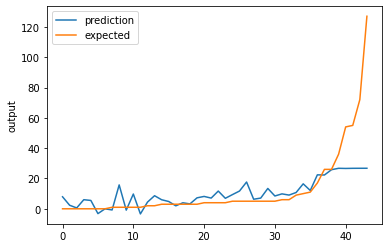

In [24]:
chart_regression(pred.flatten(), y_test, sort = True)

In [25]:
predictions = pd.DataFrame(pred, columns = ['Prediction'])
df_x = pd.DataFrame(x_test).sort_index().reset_index()
true_recommended = y_test.reset_index()

result = pd.concat([df_x, true_recommended, predictions], axis = 1)
show = result
show = show.drop(show.loc[:, ~show.columns.isin(['index', 'recommended', 'Prediction'])], axis = 1)
show.columns = ['index', 'app_id', 'recommended', 'Prediction']
show = show.drop(['index'], axis = 1)
show

,app_id,recommended,Prediction
0,73,0,7.919253
1,202,1,-0.774385
2,36,5,9.348271
3,217,55,26.696650
4,60,6,9.840070
5,112,3,7.223465
6,144,2,8.623423
7,141,3,3.966254
8,151,17,22.386215
9,213,3,5.963391


## Convolutional Neural Network Model

In [26]:
print(x.shape)
print(y.shape)

print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape(x_train.shape[0],1, x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1],1)
print(x_train.shape)
print(x_test.shape)

(219, 3505)
(219,)
(175, 3505)
(44, 3505)
(175, 1, 3505, 1)
(44, 1, 3505, 1)


**Activation = Relu**<br>
**Optimizer = Adam**<br>

In [27]:
cnn = Sequential()

cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1), activation='relu', input_shape=(1, x_train.shape[2],1)))
cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2))) 
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2))) 
cnn.add(Flatten())
cnn.add(Dense(500, activation="relu"))
cnn.add(Dropout(0.1))
cnn.add(Dense(1))

cnn.compile(loss = 'mean_squared_error', optimizer = 'adam')
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 3, verbose = 1, mode = 'auto')
cnn.fit(x_train, y_train,epochs = 1000, validation_data = (x_test, y_test), callbacks = [monitor])


pred = cnn.predict(x_test)
score_mse = metrics.mean_squared_error(pred, y_test)
print("Score (MSE): {}".format(score_mse))
    
pred = cnn.predict(x_test)
score_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score(RMSE): {}".format(score_rmse))

Epoch 1/1000
6/6 [==============================] - 1s 96ms/step - loss: 148.3600 - val_loss: 540.4648
Epoch 2/1000
6/6 [==============================] - 0s 78ms/step - loss: 116.3927 - val_loss: 585.1346
Epoch 3/1000
6/6 [==============================] - 0s 80ms/step - loss: 107.9687 - val_loss: 532.9860
Epoch 4/1000
6/6 [==============================] - 0s 82ms/step - loss: 100.4199 - val_loss: 561.6334
Epoch 5/1000
6/6 [==============================] - 0s 80ms/step - loss: 98.0259 - val_loss: 517.5493
Epoch 6/1000
6/6 [==============================] - 0s 83ms/step - loss: 91.8185 - val_loss: 534.3575
Epoch 7/1000
6/6 [==============================] - 0s 81ms/step - loss: 91.8106 - val_loss: 508.1587
Epoch 8/1000
6/6 [==============================] - 0s 81ms/step - loss: 73.7518 - val_loss: 459.0289
Epoch 9/1000
6/6 [==============================] - 0s 80ms/step - loss: 62.8715 - val_loss: 460.5863
Epoch 10/1000
6/6 [==============================] - 0s 80ms/step - loss: 53.2

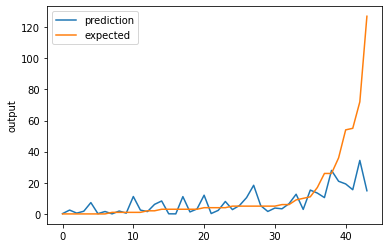

In [28]:
chart_regression(pred.flatten(), y_test, sort = True)

In [29]:
predictions = pd.DataFrame(pred, columns = ['Prediction'])
df_x = pd.DataFrame(x_test.flatten()).sort_index().reset_index()
true_recommended = y_test.reset_index()

result = pd.concat([df_x, true_recommended, predictions], axis = 1)
show = result
show = show.drop(show.loc[:, ~show.columns.isin(['index', 'recommended', 'Prediction'])], axis = 1)
show.columns = ['index', 'app_id', 'recommended', 'Prediction']
show = show.drop(['index'], axis = 1)
show = show.dropna()
show

,app_id,recommended,Prediction
0,73.0,0.0,0.203737
1,202.0,1.0,0.034826
2,36.0,5.0,2.773683
3,217.0,55.0,15.549053
4,60.0,6.0,3.291526
5,112.0,3.0,3.181770
6,144.0,2.0,6.136844
7,141.0,3.0,11.112465
8,151.0,17.0,13.386092
9,213.0,3.0,8.314644


**Activation = Sigmoid**<br>
**Optimizer = Adam**<br>

In [30]:
cnn = Sequential()

cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1), activation='sigmoid', input_shape=(1, x_train.shape[2],1)))
cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), activation='sigmoid'))
cnn.add(MaxPooling2D(pool_size=(1,2))) 
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='sigmoid'))
cnn.add(MaxPooling2D(pool_size=(1,2))) 
cnn.add(Flatten())
cnn.add(Dense(500, activation='sigmoid'))
cnn.add(Dropout(0.1))
cnn.add(Dense(1))

cnn.compile(loss = 'mean_squared_error', optimizer = 'adam')
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 3, verbose = 1, mode = 'auto')
cnn.fit(x_train, y_train,epochs = 1000, validation_data = (x_test, y_test), callbacks = [monitor])


pred = cnn.predict(x_test)
score_mse = metrics.mean_squared_error(pred, y_test)
print("Score (MSE): {}".format(score_mse))
    
pred = cnn.predict(x_test)
score_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score(RMSE): {}".format(score_rmse))

Epoch 1/1000
6/6 [==============================] - 1s 96ms/step - loss: 150.9865 - val_loss: 555.3881
Epoch 2/1000
6/6 [==============================] - 0s 82ms/step - loss: 131.7059 - val_loss: 558.2314
Epoch 3/1000
6/6 [==============================] - 0s 83ms/step - loss: 124.3390 - val_loss: 563.2990
Epoch 4/1000
6/6 [==============================] - 0s 79ms/step - loss: 118.7777 - val_loss: 569.5635
Epoch 00004: early stopping
Score (MSE): 569.5635304360013
Score(RMSE): 23.865530172950304


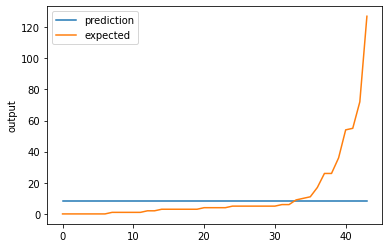

In [31]:
chart_regression(pred.flatten(), y_test, sort = True)

In [32]:
predictions = pd.DataFrame(pred, columns = ['Prediction'])
df_x = pd.DataFrame(x_test.flatten()).sort_index().reset_index()
true_recommended = y_test.reset_index()

result = pd.concat([df_x, true_recommended, predictions], axis = 1)
show = result
show = show.drop(show.loc[:, ~show.columns.isin(['index', 'recommended', 'Prediction'])], axis = 1)
show.columns = ['index', 'app_id', 'recommended', 'Prediction']
show = show.drop(['index'], axis = 1)
show = show.dropna()
show

,app_id,recommended,Prediction
0,73.0,0.0,8.280872
1,202.0,1.0,8.280872
2,36.0,5.0,8.280872
3,217.0,55.0,8.280872
4,60.0,6.0,8.280872
5,112.0,3.0,8.280872
6,144.0,2.0,8.280872
7,141.0,3.0,8.280872
8,151.0,17.0,8.280872
9,213.0,3.0,8.280872


**Activation = Tanh**<br>
**Optimizer = Adam**<br>

In [33]:
cnn = Sequential()

cnn.add(Conv2D(16, kernel_size=(1, 3), strides=(1, 1), activation='tanh', input_shape=(1, x_train.shape[2],1)))
cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1), activation='tanh'))
cnn.add(MaxPooling2D(pool_size=(1,2))) 
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), activation='tanh'))
cnn.add(MaxPooling2D(pool_size=(1,2))) 
cnn.add(Flatten())
cnn.add(Dense(500, activation='tanh'))
cnn.add(Dropout(0.1))
cnn.add(Dense(1))

cnn.compile(loss = 'mean_squared_error', optimizer = 'adam')
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 3, verbose = 1, mode = 'auto')
cnn.fit(x_train, y_train,epochs = 1000, validation_data = (x_test, y_test), callbacks = [monitor])


pred = cnn.predict(x_test)
score_mse = metrics.mean_squared_error(pred, y_test)
print("Score (MSE): {}".format(score_mse))
    
pred = cnn.predict(x_test)
score_rmse = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score(RMSE): {}".format(score_rmse))

Epoch 1/1000
6/6 [==============================] - 1s 94ms/step - loss: 141.1484 - val_loss: 551.9664
Epoch 2/1000
6/6 [==============================] - 0s 82ms/step - loss: 111.1650 - val_loss: 534.5278
Epoch 3/1000
6/6 [==============================] - 0s 79ms/step - loss: 93.5252 - val_loss: 548.8591
Epoch 4/1000
6/6 [==============================] - 0s 80ms/step - loss: 87.2059 - val_loss: 491.2534
Epoch 5/1000
6/6 [==============================] - 0s 81ms/step - loss: 73.9224 - val_loss: 534.6770
Epoch 6/1000
6/6 [==============================] - 0s 79ms/step - loss: 75.3614 - val_loss: 444.9722
Epoch 7/1000
6/6 [==============================] - 0s 80ms/step - loss: 65.3345 - val_loss: 488.8123
Epoch 8/1000
6/6 [==============================] - 0s 81ms/step - loss: 51.5574 - val_loss: 442.1779
Epoch 9/1000
6/6 [==============================] - 0s 81ms/step - loss: 44.6825 - val_loss: 453.0862
Epoch 10/1000
6/6 [==============================] - 0s 82ms/step - loss: 39.368

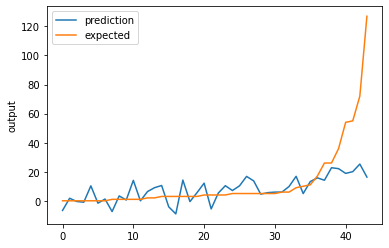

In [34]:
chart_regression(pred.flatten(), y_test, sort = True)

In [35]:
predictions = pd.DataFrame(pred, columns = ['Prediction'])
df_x = pd.DataFrame(x_test.flatten()).sort_index().reset_index()
true_recommended = y_test.reset_index()

result = pd.concat([df_x, true_recommended, predictions], axis = 1)
show = result
show = show.drop(show.loc[:, ~show.columns.isin(['index', 'recommended', 'Prediction'])], axis = 1)
show.columns = ['index', 'app_id', 'recommended', 'Prediction']
show = show.drop(['index'], axis = 1)
show = show.dropna()
show

,app_id,recommended,Prediction
0,73.0,0.0,-6.643751
1,202.0,1.0,-7.407143
2,36.0,5.0,7.049886
3,217.0,55.0,20.047983
4,60.0,6.0,6.016015
5,112.0,3.0,5.602962
6,144.0,2.0,9.023526
7,141.0,3.0,14.254622
8,151.0,17.0,15.790262
9,213.0,3.0,10.522188
